# Tratamiento de datos masivos

## Práctica 5 - Solución

- Se valorará la claridad del código y evitar redundancias o código poco eficiente. 
- Además de las funciones que se piden se pueden añadir otras auxiliares si se necesitan, y también otros imports
- El código debe funcionar correctamente no solo con las pruebas que vienen de ejemplo sino con cualquier otra prueba


## Setup

In [1]:
import os.path
from subprocess import check_call
import importlib
import os
import sys

modules = ["findspark", "pyspark", "urllib", "pyspark_dist_explore"]

if "google.colab" in sys.modules:
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    spark = "spark-3.2.0-bin-hadoop3.2.tgz"
    if not os.path.isfile(spark):
        !wget -q https://downloads.apache.org/spark/spark-3.2.0/{spark}
        !tar xf {spark}
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
        os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

print("Checking required modules")
for m in modules:
    torch_loader = importlib.util.find_spec(m)
    if torch_loader is not None:
        print(m, " found")
    else:
        print(m, " not found, installing")
        if "google.colab" in sys.modules:
            check_call(["pip", "install", "-q", m])
        else:
            check_call([sys.executable, "-m", "pip", "install", "--user", m])
print("Done!")

Checking required modules
findspark  found
pyspark  found
urllib  found
pyspark_dist_explore  found
Done!


In [2]:
"""
%matplotlib inline
import os
# cambiamos las variables del sistema
spark = 'C:/hlocal/tdm/spark/spark-3.2.0-bin-hadoop3.2'
if not(os.path.isdir(spark+"/bin")) or not(os.path.isdir(spark+"/jars")) :
        print("Error, la carpeta en 'spark' debe contener los directorios bin y jars ")
else:
        # en el path se añade
        #path = os.environ.get('PATH')
        #path = path+ ';'+spark+'\\bin;'
        #os.environ['PATH'] = path
        os.environ['SPARK_HOME']= spark
        os.environ['HADOOP_HOME']= spark
        os.environ['PYSPARK_DRIVER_PYTHON']= 'jupyter'
        os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='notebook'

        # si da problema con collect quizás haya que poner java_home a la localización de java 8
        #os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
        #os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+spark
        print("Hecho")
print("Preparado!!")
"""

'\n%matplotlib inline\nimport os\n# cambiamos las variables del sistema\nspark = \'C:/hlocal/tdm/spark/spark-3.2.0-bin-hadoop3.2\'\nif not(os.path.isdir(spark+"/bin")) or not(os.path.isdir(spark+"/jars")) :\n        print("Error, la carpeta en \'spark\' debe contener los directorios bin y jars ")\nelse:\n        # en el path se añade\n        #path = os.environ.get(\'PATH\')\n        #path = path+ \';\'+spark+\'\\bin;\'\n        #os.environ[\'PATH\'] = path\n        os.environ[\'SPARK_HOME\']= spark\n        os.environ[\'HADOOP_HOME\']= spark\n        os.environ[\'PYSPARK_DRIVER_PYTHON\']= \'jupyter\'\n        os.environ[\'PYSPARK_DRIVER_PYTHON_OPTS\']=\'notebook\'\n\n        # si da problema con collect quizás haya que poner java_home a la localización de java 8\n        #os.environ[\'JAVA_HOME\']= \'C:\\Program Files\\Java\\jdk1.8.0_151\'\n        #os.environ[\'PATH\'] = os.environ.get(\'JAVA_HOME\')+\'\\bin;\'+spark\n        print("Hecho")\nprint("Preparado!!")\n'

In [3]:
import findspark

findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


df = spark.sql("""select 'spark' as hi """)
df.show()

24/10/29 19:03:48 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.9.113.15 instead (on interface wlp0s20f3)
24/10/29 19:03:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/29 19:03:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----+
|   hi|
+-----+
|spark|
+-----+



Funciones que podemos reutilizar de la práctica anterior

In [4]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

%matplotlib inline
import pyspark.sql.functions as func


def histogram(df, col, bins=20, color="red"):
    fig, ax = plt.subplots()
    hist(ax, df.select([col]), bins=bins, color=[color])
    plt.xlabel(col)
    vs = df.select(func.mean(col), func.stddev(col)).collect()
    mean = vs[0][0]
    sd = vs[0][1]
    median = df.agg(func.percentile_approx(col, 0.5).alias("median")).collect()[0][0]
    # print(mean,sd,median,mode)
    plt.plot([mean - 1.97 * sd, mean + 1.97 * sd], [10, 10], color="blue")
    plt.plot([mean, mean], [0, -20], color="blue")
    plt.plot([median, median], [25, -15], color="green")
    plt.title(
        "Histogram of "
        + str(col)
        + ". Median: "
        + str(round(median, 2))
        + ". Mean: "
        + str(round(mean, 2))
        + ". SD: "
        + str(round(sd, 2))
    )
    plt.show()


def load_file(file):
    df = (
        spark.read.format("com.databricks.spark.csv")
        .options(header="true", inferschema="true")
        .load(file)
    )
    return df


Cargamos el fichero local en el dataframe df

In [5]:
# ahora llamamos a la función
file = "./intelhum.csv"
df = load_file(file)
print(f"{df.count()} rows")
df.printSchema()

24/10/29 19:04:02 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


4344 rows
root
 |-- C1: double (nullable = true)
 |-- C2: double (nullable = true)
 |-- C3: double (nullable = true)
 |-- C4: double (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: double (nullable = true)
 |-- C7: double (nullable = true)
 |-- C8: double (nullable = true)
 |-- C9: double (nullable = true)
 |-- C10: double (nullable = true)
 |-- C11: double (nullable = true)
 |-- C12: double (nullable = true)
 |-- C13: double (nullable = true)
 |-- C14: double (nullable = true)
 |-- C15: double (nullable = true)
 |-- C16: double (nullable = true)
 |-- C17: double (nullable = true)
 |-- C18: double (nullable = true)
 |-- C19: double (nullable = true)
 |-- C20: double (nullable = true)
 |-- C21: double (nullable = true)
 |-- C22: double (nullable = true)
 |-- C23: double (nullable = true)
 |-- C24: double (nullable = true)
 |-- C25: double (nullable = true)
 |-- C26: double (nullable = true)
 |-- C27: double (nullable = true)
 |-- C28: double (nullable = true)
 |-- C29: doub

El fichero contiene datos reales de sensores colocados en el [Intel Lab](http://db.csail.mit.edu/labdata/labdata.html).

Son 54 sensores situados en distintas partes del laboratorio

<img src="http://db.csail.mit.edu/labdata/lab.png" width=300>


Nuestro problema es que el sensor C4 se ha estropeado; y sus datos son muy importantes. Nuestro objetivo es intentar deducir su valor a partir del resto de sensores.


### Parte I: preprocesamiento

Antes de empezar veamos el número de nulos en cada columna

In [6]:
def prop_null_coll(df, c):
    total = df.count()
    nuls = df.filter(df[c].isNull()).count()
    prop = nuls * 100 / total
    return prop


def printnulls(df):
    for c in df.columns:
        print(f"Column {c} contains {round(prop_null_coll(df,c),2)}% nulls")
    return


printnulls(df)

Column C1 contains 1.17% nulls
Column C2 contains 0.58% nulls
Column C3 contains 0.58% nulls
Column C4 contains 2.58% nulls
Column C5 contains 100.0% nulls
Column C6 contains 5.13% nulls
Column C7 contains 3.06% nulls
Column C8 contains 61.03% nulls
Column C9 contains 2.35% nulls
Column C10 contains 1.15% nulls
Column C11 contains 1.08% nulls
Column C12 contains 8.77% nulls
Column C13 contains 2.33% nulls
Column C14 contains 2.33% nulls
Column C15 contains 91.32% nulls
Column C16 contains 32.44% nulls
Column C17 contains 36.1% nulls
Column C18 contains 48.25% nulls
Column C19 contains 19.43% nulls
Column C20 contains 60.93% nulls
Column C21 contains 4.28% nulls
Column C22 contains 3.15% nulls
Column C23 contains 0.97% nulls
Column C24 contains 0.94% nulls
Column C25 contains 0.92% nulls
Column C26 contains 0.3% nulls
Column C27 contains 1.27% nulls
Column C28 contains 0.71% nulls
Column C29 contains 0.55% nulls
Column C30 contains 0.46% nulls
Column C31 contains 1.1% nulls
Column C32 c

**Ejercicio 1** [1.5]

En primer lugar tenemos que eliminar los nulos. Para ello:

a) Borrar todas las columnas con al menos un 5% de columnas [drop](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.drop.html)

b)Ahora en df2 borramos todas las filas con algún nulo. Para ello  en [esta página](https://sparkbyexamples.com/pyspark/pyspark-drop-rows-with-null-values/) (buscar el epígrafe "Drop Rows with NULL Values in Any Columns") El resultado será un dataframe df3


c) Finalmente cambiamos el nombre de `C4` por el de `label` ([withColumnRenamed](https://sparkbyexamples.com/pyspark/pyspark-rename-dataframe-column/)). El resultado será el dataframe df4

In [10]:
# sol
#  a
df2 = df  # para empezar
for column in df.columns:
    if prop_null_coll(df, column) >= 5:
        df2 = df2.drop(column)

# b
df3 = df2.na.drop()

# c
df4 = df3.withColumnRenamed("C4", "label")

# test
printnulls(df4)


24/10/29 19:18:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Column C1 contains 0.0% nulls
Column C2 contains 0.0% nulls
Column C3 contains 0.0% nulls
Column label contains 0.0% nulls
Column C7 contains 0.0% nulls
Column C9 contains 0.0% nulls
Column C10 contains 0.0% nulls
Column C11 contains 0.0% nulls
Column C13 contains 0.0% nulls
Column C14 contains 0.0% nulls
Column C21 contains 0.0% nulls
Column C22 contains 0.0% nulls
Column C23 contains 0.0% nulls
Column C24 contains 0.0% nulls
Column C25 contains 0.0% nulls
Column C26 contains 0.0% nulls
Column C27 contains 0.0% nulls
Column C28 contains 0.0% nulls
Column C29 contains 0.0% nulls
Column C30 contains 0.0% nulls
Column C31 contains 0.0% nulls
Column C33 contains 0.0% nulls
Column C34 contains 0.0% nulls
Column C36 contains 0.0% nulls
Column C37 contains 0.0% nulls
Column C38 contains 0.0% nulls
Column C39 contains 0.0% nulls
Column C40 contains 0.0% nulls
Column C54 contains 0.0% nulls


### Parte 2 : regresión lineal

**Ejercicio 2** [0.5 puntos] Transformar df4 para que todas columnas salvo label  estén juntas en un vector con nombre features. Llamar al nuevo dataframe dataprep

In [16]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


def prepare_features(df):
    # solución
    vecAssembler = VectorAssembler(
        inputCols=[column for column in df4.columns if column != "label"],
        outputCol="features",
    )
    dataprep = vecAssembler.transform(df)
    dataprep = dataprep.select("features", "label")
    return dataprep


dataprep = prepare_features(df4)

#### test
dataprep.show(5)

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[38.8379,39.7557,...|39.2803|
|[38.9061,39.6878,...|39.1443|
|[39.0422,39.586,3...|39.4842|
|[38.8379,39.5521,...|39.1443|
|[39.0082,39.5521,...|39.4842|
+--------------------+-------+
only showing top 5 rows



**Ejercicio 3** [3 puntos]

Llevar a cabo la regresión lineal. Para ello:

* Dividir `dataprep` en conjunto de entrenamiento (20%) y de test (80%)
* Declarar un método de regresión lineal sin parámetros
* Aplicar el método al conjunto train para obtener un modelo
* Aplicar el modelo tanto al train como al test. En el primer caso las predicciones se llamarán train_pred, y en el segundo test_pred
* Declarar evaluadores para RMSE y para R2
* Mostrar ambas métricas sobre train_pred y sobre test_pred


In [25]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

test, train = dataprep.randomSplit([0.2, 0.8])
lr = LinearRegression()
model = lr.fit(train)
test_pred = model.transform(test)
train_pred = model.transform(test)
r2_evaluator = RegressionEvaluator(metricName="r2")
rmse_evaluator = RegressionEvaluator(metricName="rmse")
r2_test = r2_evaluator.evaluate(test_pred)
rmse_test = rmse_evaluator.evaluate(test_pred)
r2_train = r2_evaluator.evaluate(train_pred)
rmse_train = rmse_evaluator.evaluate(train_pred)
print(f"R^2 test {r2_test}")
print(f"RMSE test {rmse_test}")
print(f"R^2 train {r2_train}")
print(f"RMSE test {rmse_train}")

24/10/29 19:37:45 WARN Instrumentation: [b9be675b] regParam is zero, which might cause numerical instability and overfitting.


R^2 test 0.9028086963101873
RMSE test 5.21050522756811
R^2 train 0.9028086963101873
RMSE test 5.21050522756811


### Parte 3. Análisis y evaluación de los resultados

El siguiente nos mostrará una gráfica comparando los valores reales del test (verde) y los predichos (azul), uniendo ambos con una línea amarilla

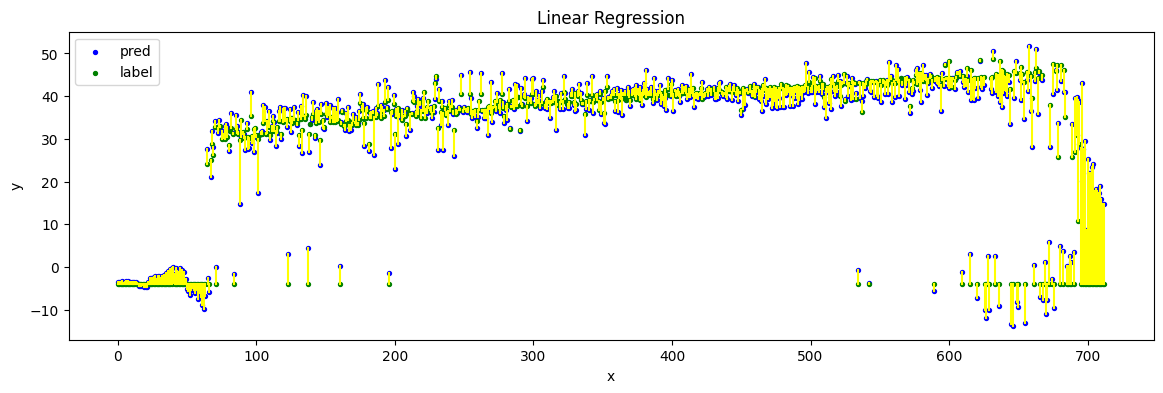

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline


def scatter_pred_real(predictions, title):
    preds = predictions.collect()

    ylabel = [row[1] for row in preds]
    ypred = [row[2] for row in preds]
    x = list(range(len(ylabel)))

    plt.rcParams["font.size"] = 10
    figure, ax = plt.subplots(1, figsize=(14, 4), dpi=100)
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [ypred[i], ylabel[i]], color="yellow")

    plt.scatter(x, ypred, color="blue", label="pred", s=8)
    plt.scatter(x, ylabel, color="green", label="label", s=8)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(title)
    plt.show()


scatter_pred_real(test_pred, "Linear Regression")

Algo extraño pasa, especialmente si consideramos que la humedad nunca puede bajar del 0%. Esto nos pasa por no hacer el histograma lo primero. Hagámoslo ahora:

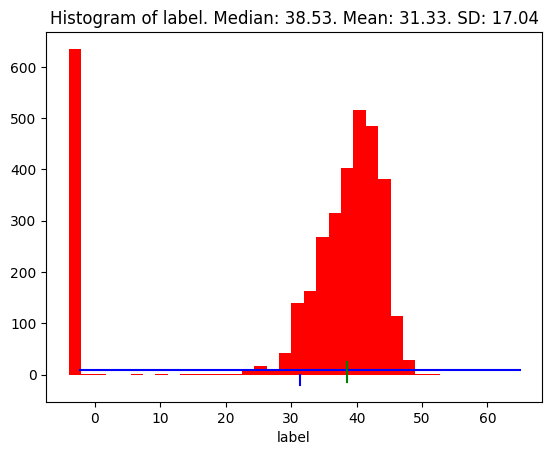

In [27]:
histogram(dataprep, "label", bins=30)

Es un caso clarísimo de outlayers. Para solucionarlo

**Ejercicio 4** [1] Escribir código para modificar dataprep de forma que se eliminen todas las filas con 'label' menor o igual a 0 mediante la función [filter](https://sparkbyexamples.com/pyspark/pyspark-where-filter/). El resultado se llamará dataprep2. 



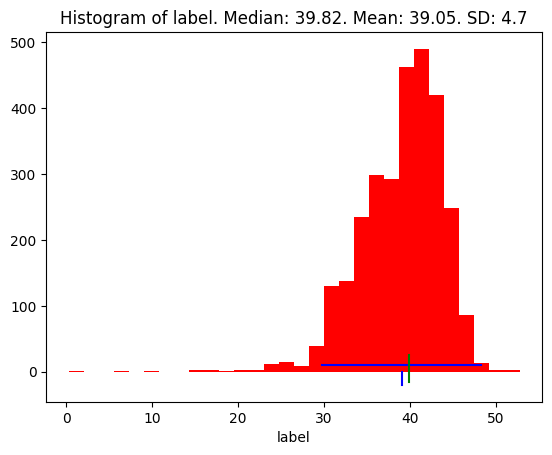

In [29]:
dataprep2 = dataprep.filter(dataprep.label > 0)

# test
histogram(dataprep2, "label", bins=30)

Solo para probar

In [30]:
df5 = df4
for c in df4.columns:
    df5 = df5.filter(c + ">=0")
    df5 = df5.filter(c + "<=100")

dataprep2 = prepare_features(df5)

#### test
dataprep2.show(5)

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[38.8379,39.7557,...|39.2803|
|[38.9061,39.6878,...|39.1443|
|[39.0422,39.586,3...|39.4842|
|[38.8379,39.5521,...|39.1443|
|[39.0082,39.5521,...|39.4842|
+--------------------+-------+
only showing top 5 rows



**Ejercicio 5** [0.5pt] 
Escribir código que calcule la skewness o asimetría y la curtosis, y escriba de qué tipo es esta gráfica. Utiliza las funciones "skewness, kurtosis" del paquete pyspark.sql.functions.


In [42]:
from pyspark.sql.functions import skewness, kurtosis

# sol.
asimetria, curtosis = dataprep2.select(
    skewness(dataprep2.label), kurtosis(dataprep2.label)
).first()

if asimetria < 0:
    print("Asimetría a la izquierda")
elif asimetria == 0:
    print("Simetría")
elif asimetria > 0:
    print("Asimetría a la derecha")

if curtosis < 3:
    print("platykurtica")
elif curtosis == 3:
    print("mesokurtótica")
elif curtosis > 3:
    print("leptocurtótica")

Asimetría a la izquierda
leptocurtótica


**Ejercicio 6** [1.5pt] Queremos repetir la regresión lineal para ver si da mejores resultados. En este caso solo nos interesa el RSME del test. Como sospechamos que puede que queramos repetir otra vez el código vamos a hacer una función

- Name: try_regression
- Param.: 
     - data: un dataframe que tiene dos columnas, features y label
     - method: un método de regresión, ya con sus  hiperparámetros
- Salida: una tupla con dos valores el RMSE sobre el conjunto de test, y las propias predicciones sobre el test

Nota: no hace falta mostrar nada por pantalla


24/10/29 19:53:48 WARN Instrumentation: [48e7f5aa] regParam is zero, which might cause numerical instability and overfitting.


RMSE: 2.8777780668534


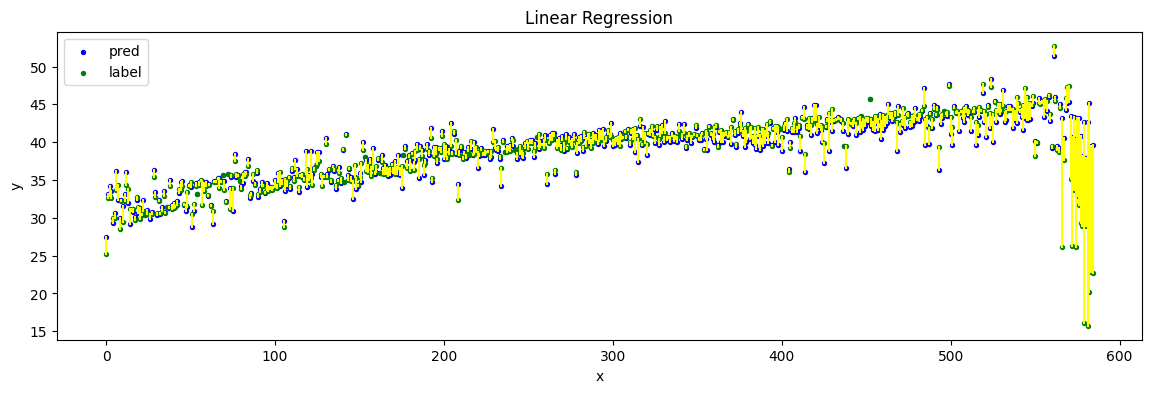

In [46]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


def try_regression(data, method):
    test, train = data.randomSplit([0.2, 0.8])
    model = method.fit(train)
    test_pred = model.transform(test)
    rmse_evaluator = RegressionEvaluator(metricName="rmse")
    rmse = rmse_evaluator.evaluate(test_pred)
    return rmse, test_pred


rmse, test_pred = try_regression(dataprep2, LinearRegression())
print("RMSE:", rmse)
scatter_pred_real(test_pred, "Linear Regression")

**Ejercicio 7** [1 p.] Como el RMSE depende mucho de la división entre test y train nos interesa repetir el experimento y obtener un RMSE promediado. Escribir una función:

- name: repeat_regression
- Param.: 
     - data: un dataframe que tiene dos columnas, features y label
     - method: un método de regresión, ya con sus  hiperparámetros
     - n: el número de veces que queremos repetir el experimeto
- Salida: Una tupla con el RMSE medio de los n experimentos y las predicciones sobre el test de uno de esos experimentos

Nota: el método debe llamar a `try_regression`


In [47]:
def repeat_regression(data, method, n):
    rmse = 0
    for _ in range(n):
        rmse_temp, test_pred = try_regression(data, method)
        rmse += rmse_temp
    rmse /= n
    return rmse, test_pred


## test
rmse, _ = repeat_regression(dataprep2, LinearRegression(), 10)
print("RMSE", rmse)

24/10/29 19:55:08 WARN Instrumentation: [9a6f711f] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:55:09 WARN Instrumentation: [4ef05962] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:55:10 WARN Instrumentation: [c8e40ecd] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:55:10 WARN Instrumentation: [d2f7caca] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:55:11 WARN Instrumentation: [1a617fc8] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:55:12 WARN Instrumentation: [0a278159] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:55:13 WARN Instrumentation: [94c407ef] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:55:14 WARN Instrumentation: [225ac9bb] regParam is zero, which might cause numerical instability and overf

RMSE 2.4470437618798107


**Ejercicio 8** [1pt.] Como sabemos hay otros métodos para hacer regresión. La variable `methods`contiene el nombre de algunos de ellos junto con una declaración del método. Hacer un bucle para:


- Calcular con repeat_regression la media de 10 experimentos con el método tal y como está declarado
- Mostrar el test_pred devuelto por repeat_regression mediante `scatter_pred_real`, incluye como parámetro para el título el nombre del método y el RMSE

RMSE: 2.72565704529765


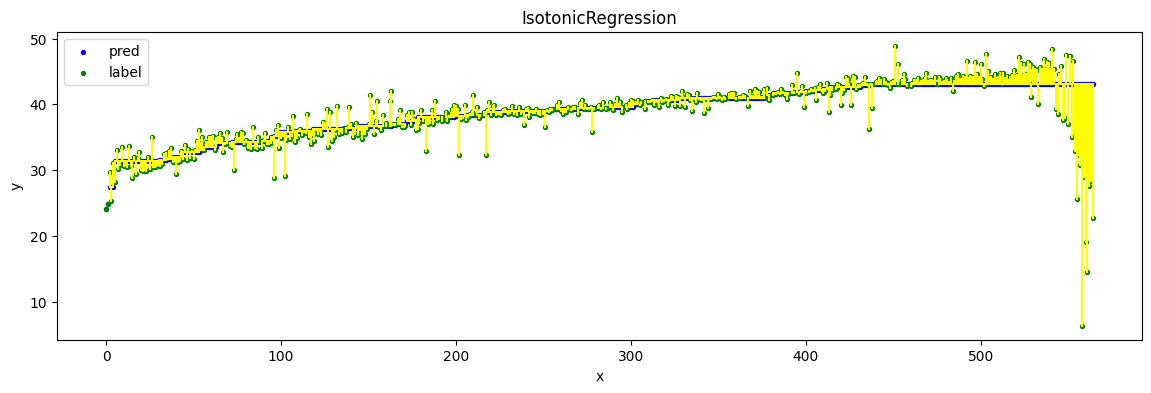

24/10/29 19:57:06 WARN Instrumentation: [19e84542] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:07 WARN Instrumentation: [b3990e37] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:07 WARN Instrumentation: [6087add1] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:08 WARN Instrumentation: [b1c41424] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:09 WARN Instrumentation: [393d7112] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:09 WARN Instrumentation: [2c77045b] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:10 WARN Instrumentation: [a77cbb11] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:11 WARN Instrumentation: [a1e86f99] regParam is zero, which might cause numerical instability and overf

RMSE: 2.5599874219062007


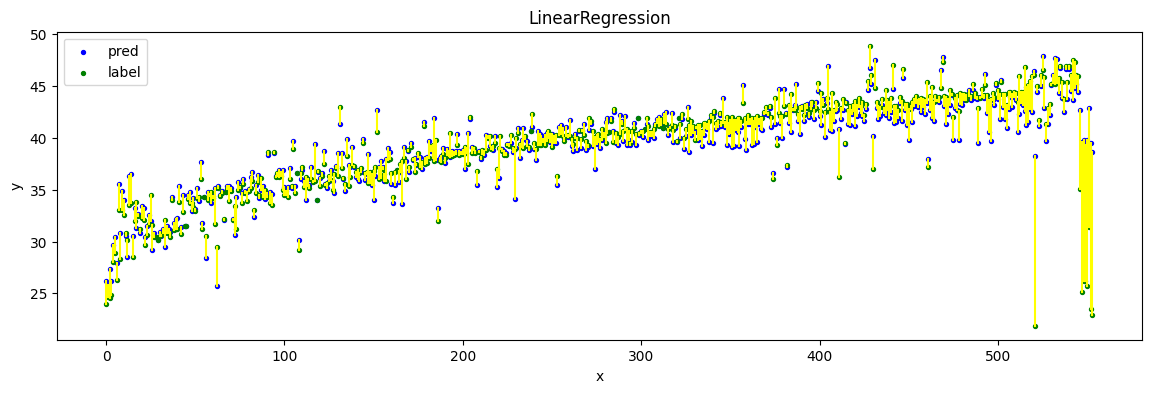

24/10/29 19:57:14 WARN Instrumentation: [dead1c9b] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:15 WARN Instrumentation: [dad82bc1] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:15 WARN Instrumentation: [1a4e420b] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:16 WARN Instrumentation: [fbe7197a] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:17 WARN Instrumentation: [7959e8c4] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:17 WARN Instrumentation: [0ed36b57] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:18 WARN Instrumentation: [0e7f69da] regParam is zero, which might cause numerical instability and overfitting.
24/10/29 19:57:18 WARN Instrumentation: [dcf377f0] regParam is zero, which might cause numerical instability and overf

RMSE: 2.6811105798917083


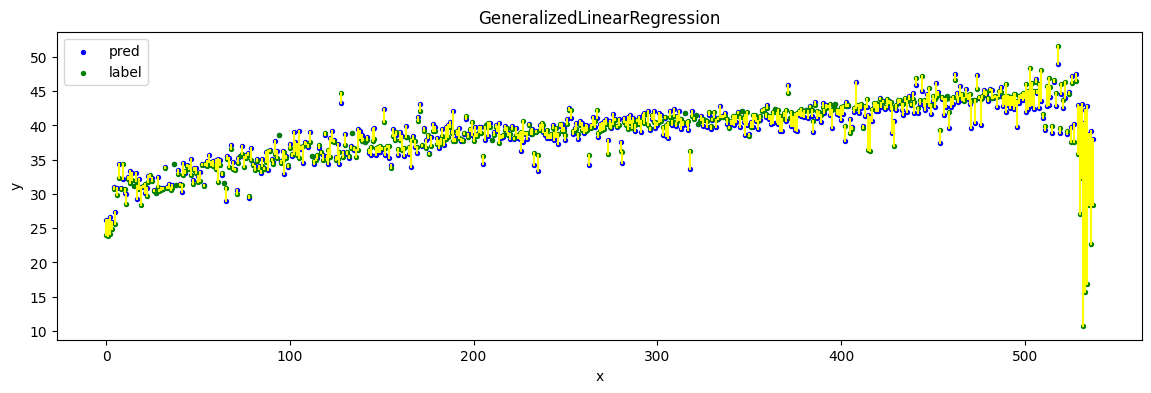

RMSE: 1.5398312008109876


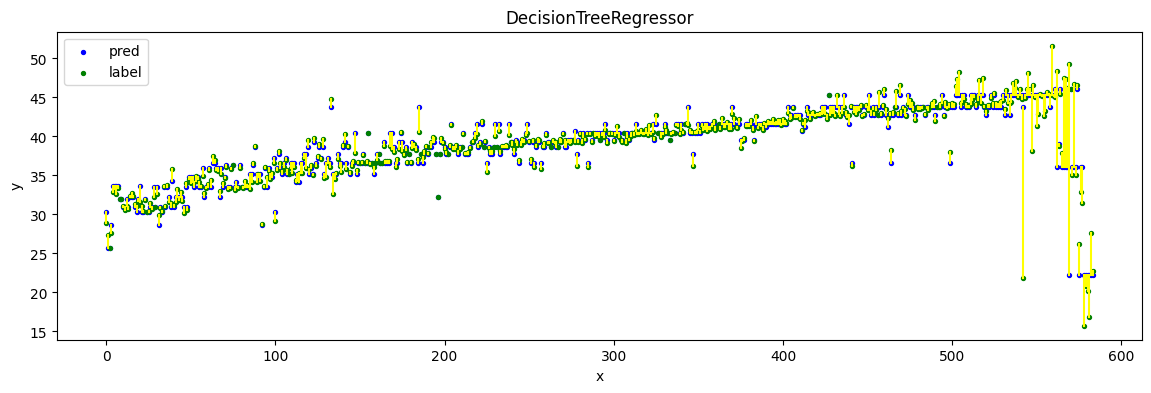

In [48]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import IsotonicRegression

methods = [
    ("IsotonicRegression", IsotonicRegression()),
    ("LinearRegression", LinearRegression()),
    ("GeneralizedLinearRegression", GeneralizedLinearRegression()),
    ("DecisionTreeRegressor", DecisionTreeRegressor()),
]

for method in methods:
    rmse, test_pred = repeat_regression(dataprep2, method[1], 10)
    print("RMSE:", rmse)
    scatter_pred_real(test_pred, method[0])